In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import pickle

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(context='paper')

In [2]:
# загрузим данные

images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/ph2dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [3]:
# ресайз 256х256

from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
# преобразуем в данные в итеррируемый объект

import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


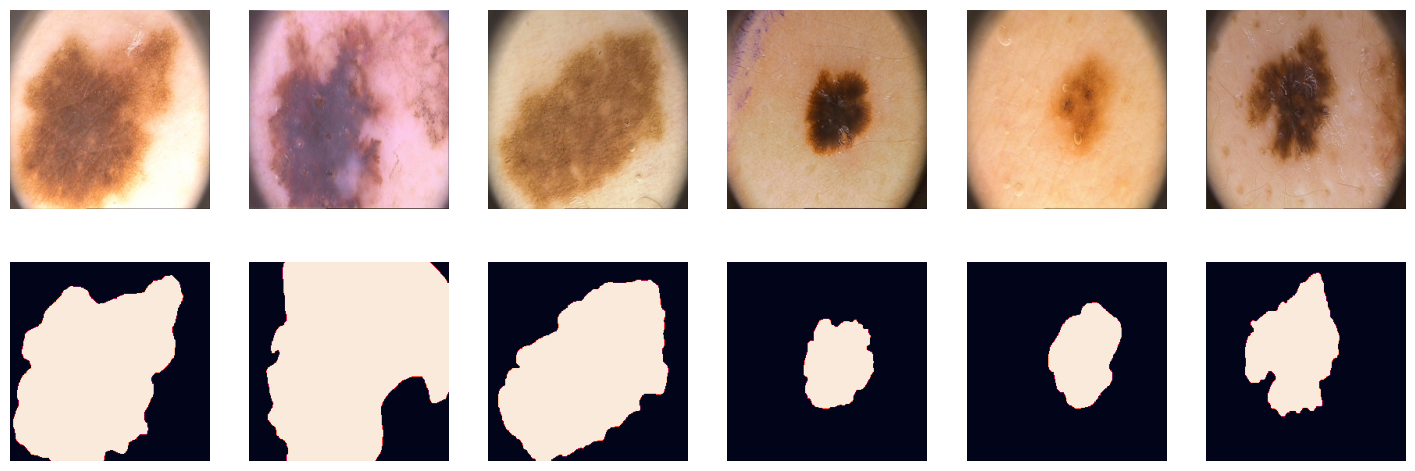

In [5]:
# визуализация

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [29]:
# рандомизируем выборку и делим на train и test, соревнование нам в этот раз не дали, поэтому поделим 150 / 50 и попробуем выбрать лучшую архитектуру
# и функцию потерь для "возможной" валидации без правильного ответа

ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [150])

In [7]:
# создадим dataloader

from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)

In [8]:
# подключим и проверим GPU

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
# метрика IoU

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

In [10]:
# реализуем loss bce, dice, focal, tversky, lova

def bce_loss(y_pred, y_real):
    y_pred = y_pred.float()
    y_real = y_real.float()
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return torch.mean(bce)

In [11]:
def dice_loss(outputs, labels):
    SMOOTH = 1e-8
    outputs = torch.sigmoid(outputs)
    num = 2 * (outputs * labels).sum()
    den = (outputs + labels).sum()
    res = 1 - (num + SMOOTH) / (den + SMOOTH)
    return res

In [12]:
def focal_loss(y_pred, y_real):
    alpha = 1
    gamma = 2
    bce_logit = nn.BCEWithLogitsLoss()
    ce = bce_logit(y_pred, y_real)
    pt = torch.exp(-ce)
    fl = alpha * torch.pow((1 - pt), gamma) * ce
    return fl

In [13]:
def tversky_loss(y_pred, y_real):
    alpha = 0.7
    beta = 0.3
    y_pred = torch.sigmoid(y_pred)
    pp = (y_real * y_pred).sum()
    den1 = alpha * ((1 - y_real) * y_pred).sum()
    den2 = beta * (y_real * (1 - y_pred)).sum()
    tl = 1 - (1 + pp) / (1 + pp + den1 + den2)
    return tl       

In [14]:
def lova_loss(y_pred, y_real):
    
    y_pred = y_pred.flatten()
    y_real = y_real.flatten()
    signs = 2 * y_real.float() - 1
    errors = (1 - y_pred * signs)
    errors_sorted, indices = torch.sort(errors, dim=0, descending=True)
    gt_sorted = y_real[indices.data]

    # gradient
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    grad = 1. - intersection / union

    p = len(gt_sorted)
    grad[1:p] = grad[1:p] - grad[0:-1]
       
    loss = torch.dot(torch.relu(errors_sorted), grad)
    return loss

In [15]:
# train, добавим листы с лоссами и метриками для будущей визуализации

def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    losses = []
    metrics = []
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu

        losses.append(avg_loss.item())
        metrics.append(score_model(model, iou_pytorch, data_val))
        
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses, metrics

In [16]:
# predict с отключенным расчетом градиентов

def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
# скоринговая модель для нашей метрики

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        with torch.no_grad():
            Y_pred = model(X_batch)
            Y_pred = Y_pred.to(device)
            Y_label = Y_label.to(device)
        scores += metric((torch.sigmoid(Y_pred) > 0.5), Y_label).mean().item()

    return scores/len(data)

In [18]:
# реализация SegNet

class SegNet(nn.Module):
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _dec_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
  
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(self._enc_layer(3, 64), self._enc_layer(64, 64))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(self._enc_layer(64, 128), self._enc_layer(128, 128))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(self._enc_layer(128, 256), self._enc_layer(256, 256), self._enc_layer(256, 256))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(self._enc_layer(256, 512), self._enc_layer(512, 512), self._enc_layer(512, 512))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
        # bottleneck?
        # self.bottleneck_conv = 
        # https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html        
        self.enc_conv_bn = nn.Sequential(self._enc_layer(512, 512), self._enc_layer(512, 512), self._enc_layer(512, 512))
        self.pool_bn = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
        self.upsample_bn = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.dec_conv_bn = nn.Sequential(self._dec_layer(512, 512), self._dec_layer(512, 512), self._dec_layer(512, 512))
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(self._dec_layer(512, 512), self._dec_layer(512, 512), self._dec_layer(512, 256))
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(self._dec_layer(256, 256), self._dec_layer(256, 256), self._dec_layer(256, 128))
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(self._dec_layer(128, 128), self._dec_layer(128, 64))
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._dec_layer(64, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=(1, 1)),
            # nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.ReLU(inplace=True)
       )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        # b = self.bottleneck_conv(e3)
        p, idx_bn = self.pool_bn(self.enc_conv_bn(e3))
        b = self.dec_conv_bn(self.upsample_bn(p, idx_bn))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0)) # no activation
        return d3

In [19]:
# реализация UNet

class UNet(nn.Module):
    
    def _conv_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._conv_conv(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc_lr0 = self._enc_layer(64, 128)
        self.enc_lr1 = self._enc_layer(128, 256)
        self.enc_lr2 = self._enc_layer(256, 512)
        self.enc_lr3 = self._enc_layer(512, 512)
        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)#ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = self._conv_conv(2 * 512, 256)
        self.upsample1 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self._conv_conv(2 * 256, 128)
        self.upsample2 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = self._conv_conv(2 * 128, 64)
        self.upsample3 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._conv_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_lr0(e0)
        e2 = self.enc_lr1(e1)
        e3 = self.enc_lr2(e2)
        # bottleneck
        b = self.upsample0(self.enc_lr3(e3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [20]:
# реализация UNet2 Max-Pooling for the downsampling and nearest-neighbor Upsampling for the upsampling.

class UNet2(nn.Module):
    
    def _conv_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1),
            self._conv_conv(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc_lr0 = self._enc_layer(64, 128)
        self.enc_lr1 = self._enc_layer(128, 256)
        self.enc_lr2 = self._enc_layer(256, 512)
        self.enc_lr3 = self._enc_layer(512, 1024)
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = self._conv_conv(2 * 512, 512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self._conv_conv(2 * 256, 256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = self._conv_conv(2 * 128, 128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._conv_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_lr0(e0)
        e2 = self.enc_lr1(e1)
        e3 = self.enc_lr2(e2)
        
        # bottleneck
        b = self.upsample0(self.enc_lr3(e3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [21]:
# функция для обучения, валидации и будущей визуализации всех выбранных архитектур и лоссов

def validate_all_model(model_class, model_file, pickle_file, max_epochs=40):
    loss = {
        'bce': bce_loss,
        'dice': dice_loss,
        'focal': focal_loss,
        'tversky': tversky_loss,
        'lovasz': lova_loss,
    }
    model_history = {}
    for loss_name, loss_func in loss.items():
        model_history[loss_name] = {}
        model = model_class().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        losses, metric = train(model, optimizer, loss_func, max_epochs, data_tr, data_val)
        model_history[loss_name]['losses'] = losses
        model_history[loss_name]['metric'] = metric
        torch.save(model, '{}_{}_{}epoch.model'.format(model_file, loss_name, max_epochs))
    with open(pickle_file, 'wb') as handle:
        pickle.dump(model_history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return model_history

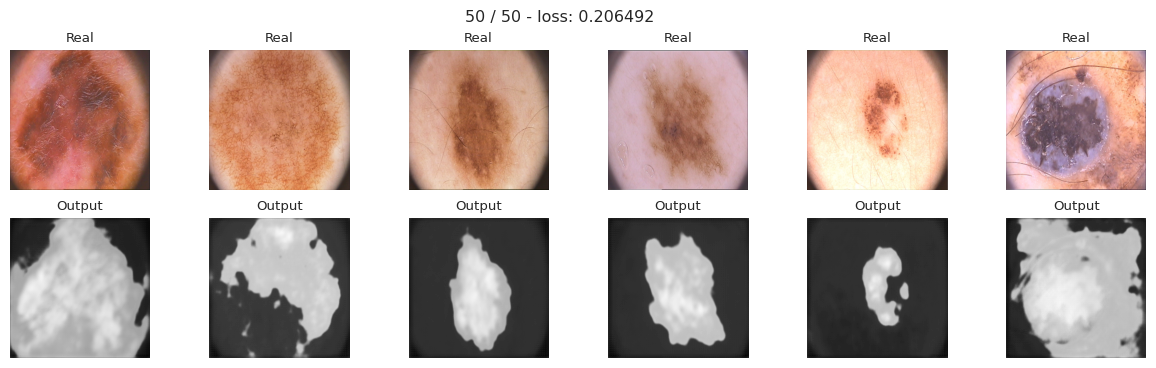

In [22]:
# Модели оказались не склонны к переобучению, запустим на 50 эпох

max_epochs = 50
segnet_res = validate_all_model(SegNet, 'segnet', 'segnet.pickle', max_epochs=max_epochs)
unet_res = validate_all_model(UNet, 'unet', 'unet.pickle', max_epochs=max_epochs)
unet2_res = validate_all_model(UNet2, 'unet2', 'unet2.pickle', max_epochs=max_epochs)

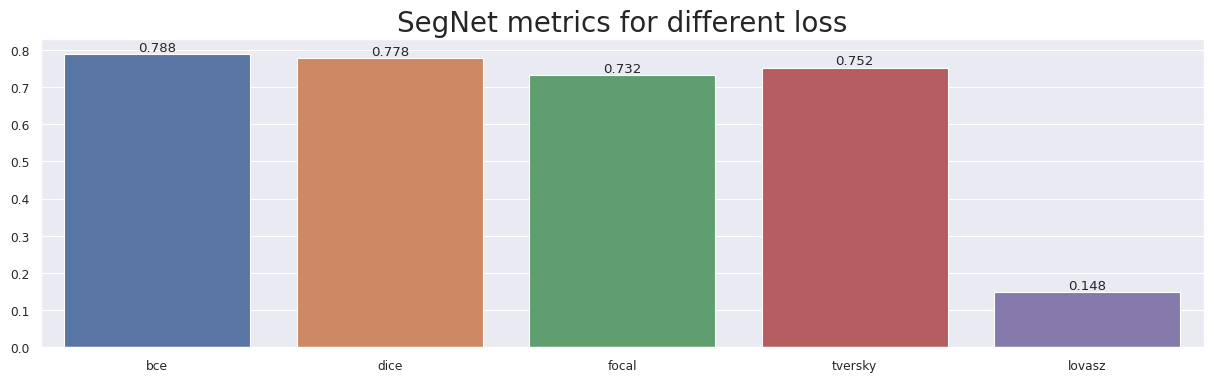

In [23]:
# визуализация метрик для SegNet

ax = sns.barplot(x=list(segnet_res.keys()), y=[max(m['metric']) for m in segnet_res.values()])
ax.bar_label(ax.containers[0])
ax.set_title('SegNet metrics for different loss', fontsize=20)
plt.show()

Lova loss показал неоднозначный результат для SegNet, может показаться, что это указывает на неправильную реализацию, но на других моделях корректный результат. Возможно ошибка связана с работой сервера kaggle (картинка ниже)

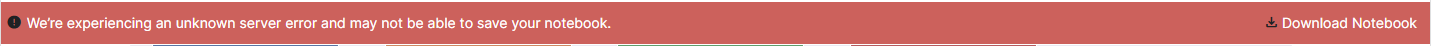

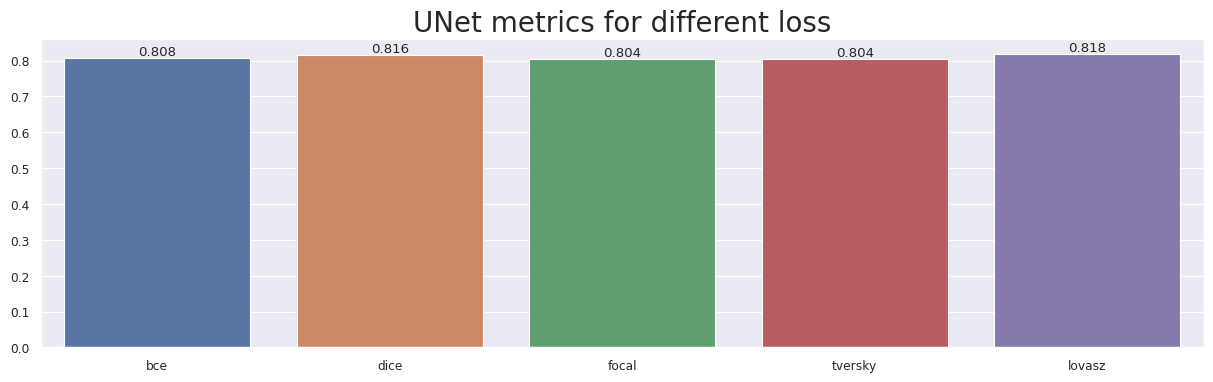

In [24]:
# визуализация метрик для UNet

ax = sns.barplot(x=list(unet_res.keys()), y=[max(m['metric']) for m in unet_res.values()])
ax.bar_label(ax.containers[0])
ax.set_title('UNet metrics for different loss', fontsize=20)
plt.show()

In [ ]:
Для UNet все loss показали хороший результат, лучший Lova_loss, который показал худший перфоманс на SegNet

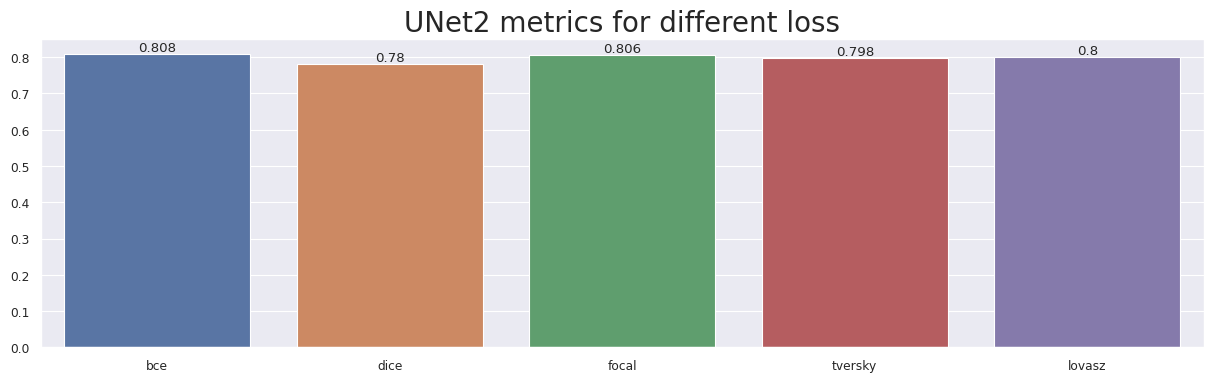

In [25]:
# визуализация метрик для UNet2

ax = sns.barplot(x=list(unet2_res.keys()), y=[max(m['metric']) for m in unet2_res.values()])
ax.bar_label(ax.containers[0])
ax.set_title('UNet2 metrics for different loss', fontsize=20)
plt.show()

In [ ]:
Для UNet2 все loss так же показали хороший результат, лучший Lova_loss, который показал худший перфоманс на SegNet

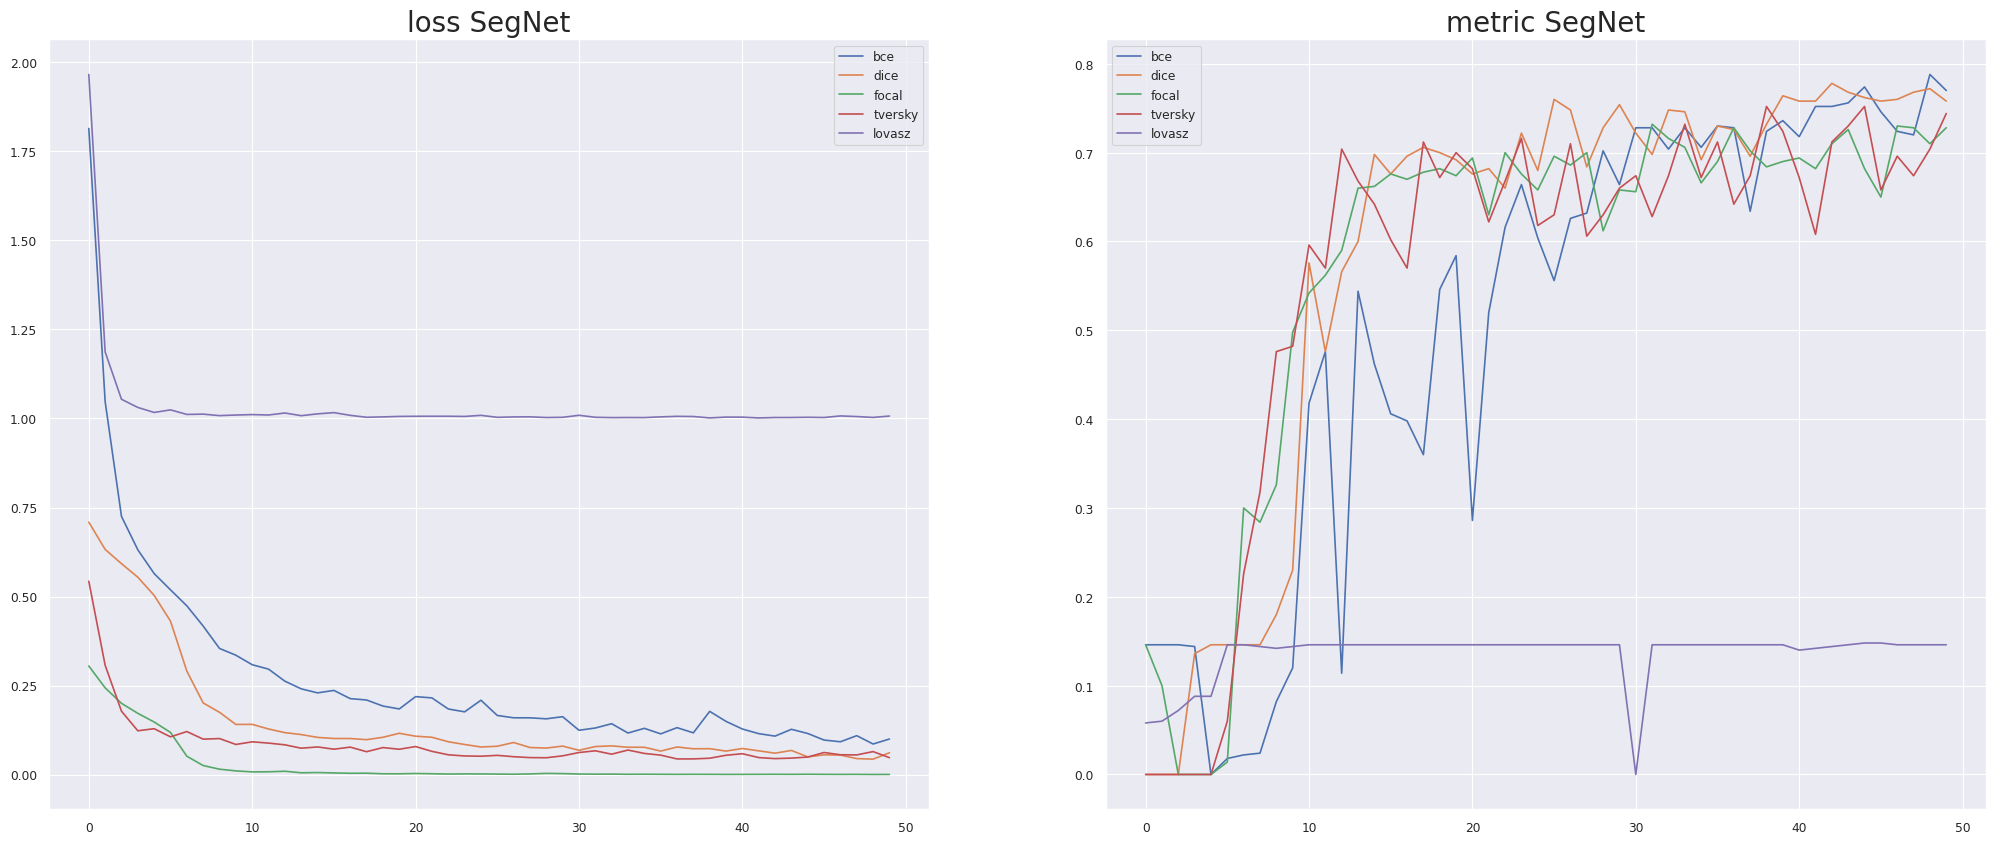

In [26]:
# Визуализация loss и metric для SegNet

fig, ax = plt.subplots(1, 2, figsize=(25,10))
x = list(range(max_epochs))
for key, value in segnet_res.items():
    sns.lineplot(x=x, y=value['losses'], ax=ax[0], label=key)
    sns.lineplot(x=x, y=value['metric'], ax=ax[1], label=key)
ax[0].set_title('loss SegNet', fontsize=20)
ax[1].set_title('metric SegNet', fontsize=20)
ax[0].legend()
ax[1].legend()
fig.show()

Проблемы с lova_loss, как описано выше. loss быстро падает за первые 10 эпох. Метрики сильно штормит, но после 30 эпохи выравниваются. Переобучения не наблюдается, вопросы только к lova_loss, возмо стоит попробовать обучить его еще раз

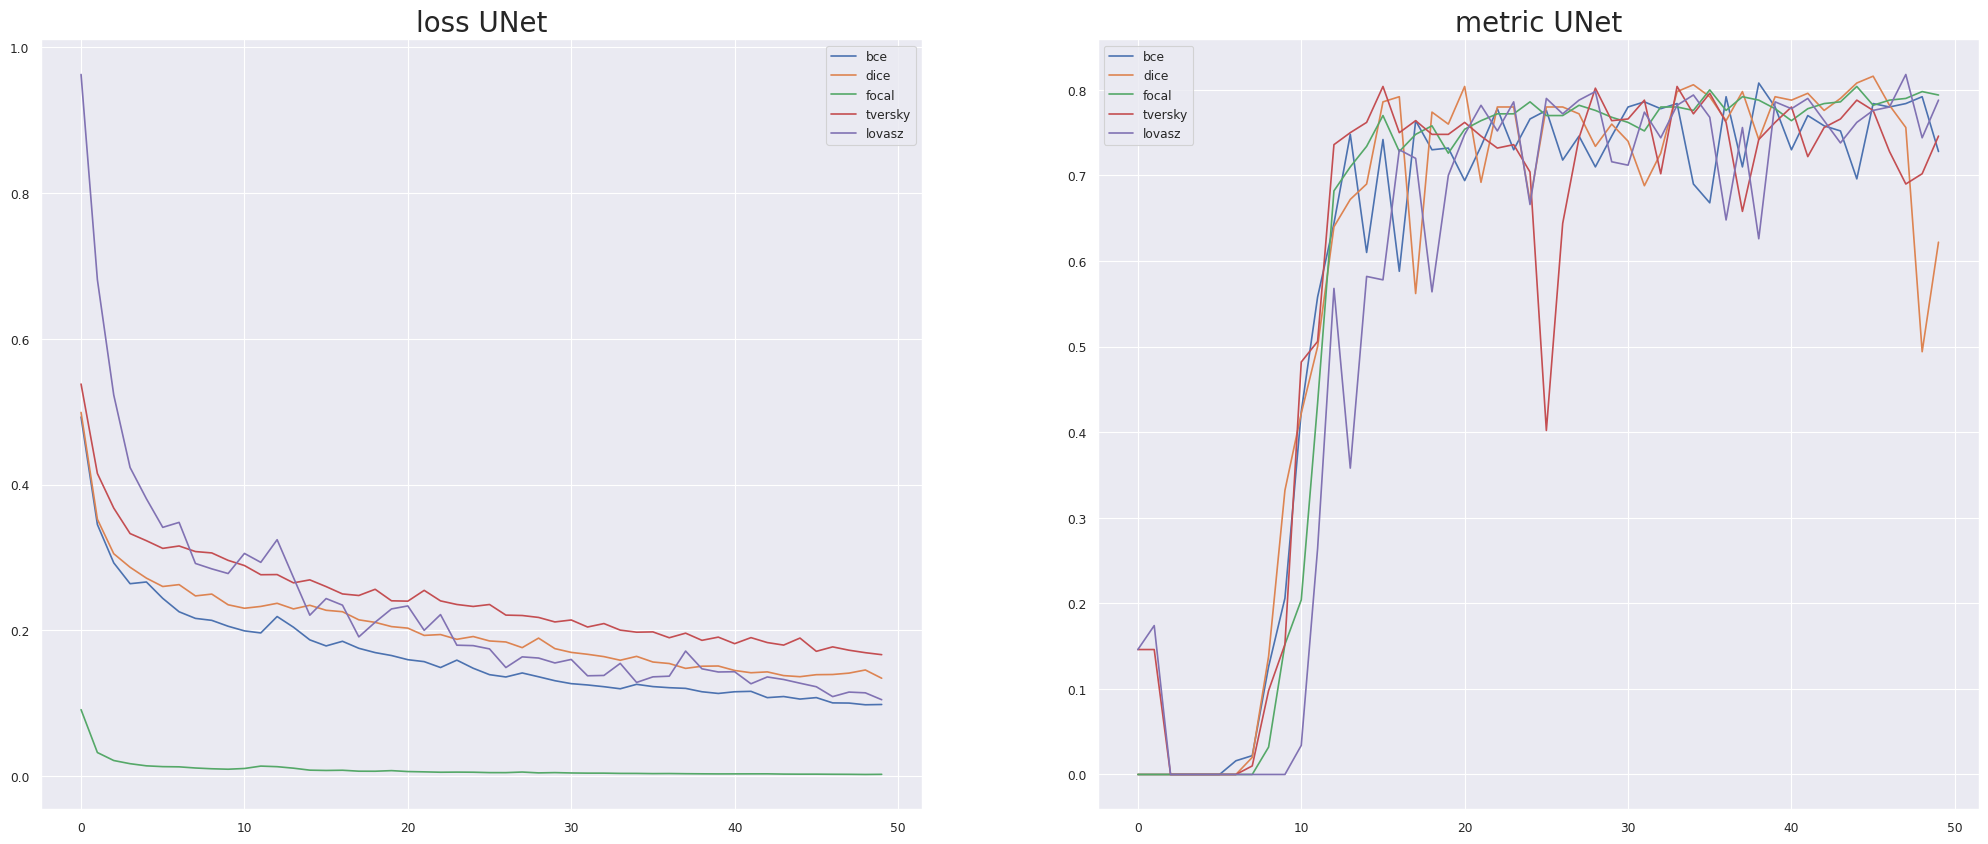

In [27]:
# Визуализация loss и metric для UNet

fig, ax = plt.subplots(1, 2, figsize=(25,10))
x = list(range(max_epochs))
for key, value in unet_res.items():
    sns.lineplot(x=x, y=value['losses'], ax=ax[0], label=key)
    sns.lineplot(x=x, y=value['metric'], ax=ax[1], label=key)
ax[0].set_title('loss UNet', fontsize=20)
ax[1].set_title('metric UNet', fontsize=20)
ax[0].legend()
ax[1].legend()
fig.show()

Все модели на всех лоссах быстро сходятся (к 10 эпохе). focal loss максимально приближается к 0. Tversky и dice просели на каких-то батчах, но выровнялись. UNet можно запустить и на 100 эпох

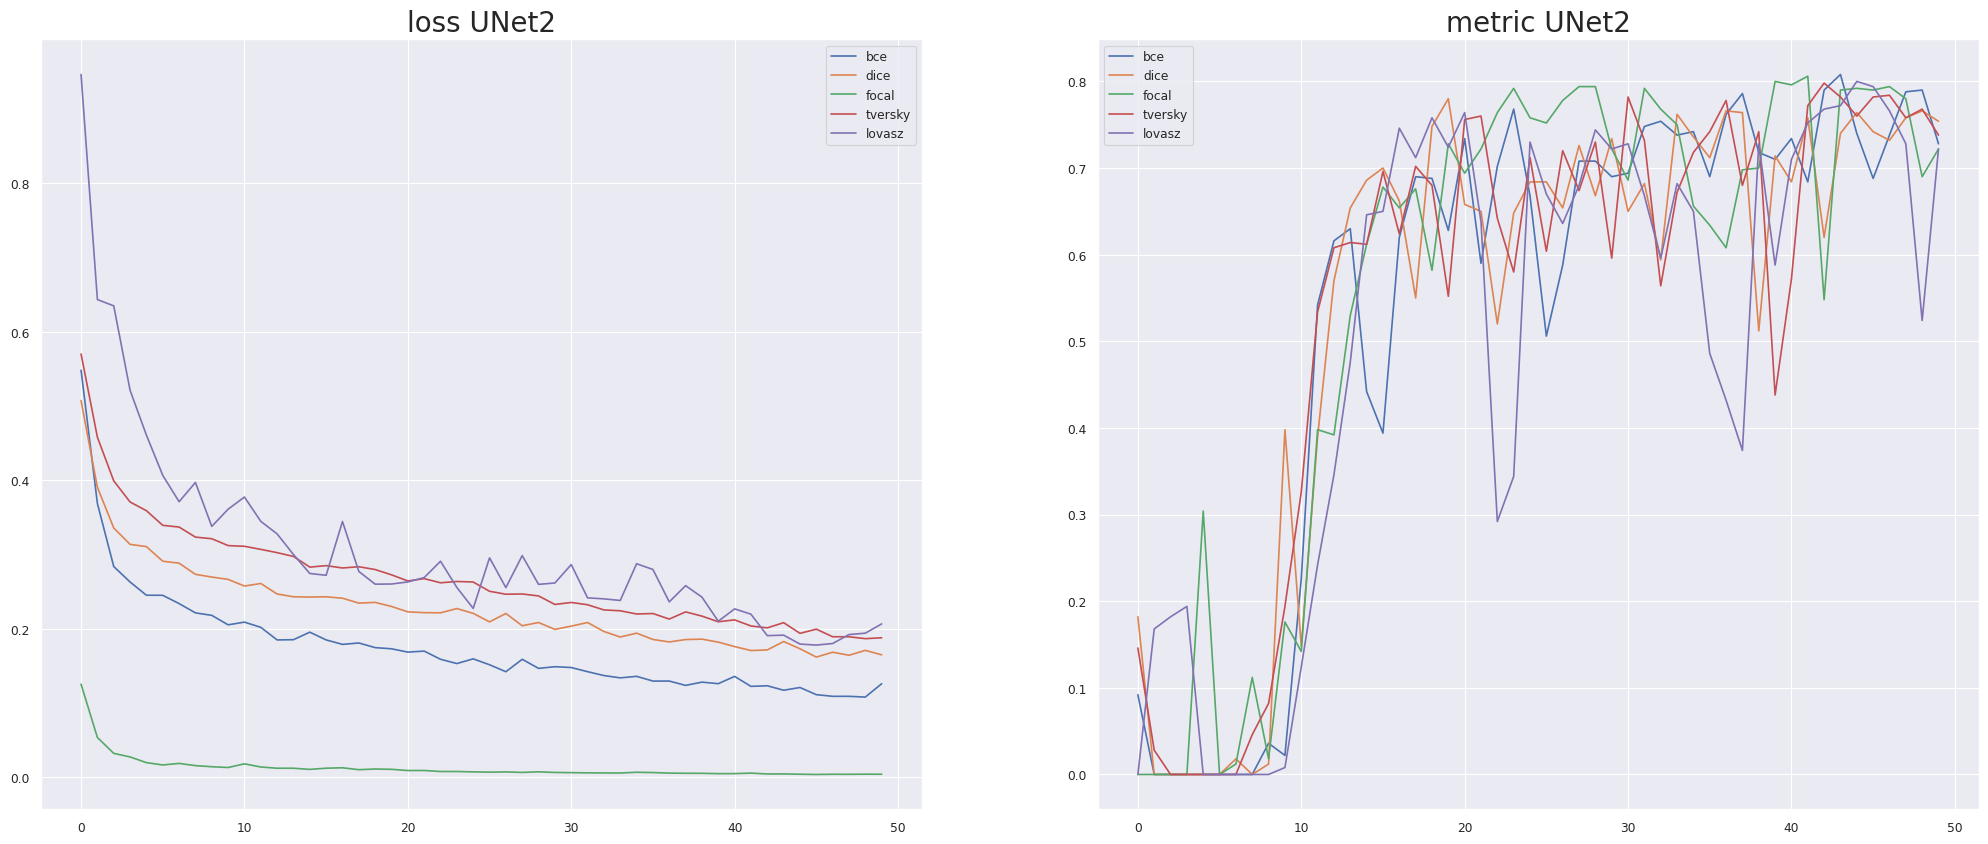

In [28]:
# Визуализация loss и metric для UNet2

fig, ax = plt.subplots(1, 2, figsize=(25,10))
x = list(range(max_epochs))
for key, value in unet2_res.items():
    sns.lineplot(x=x, y=value['losses'], ax=ax[0], label=key)
    sns.lineplot(x=x, y=value['metric'], ax=ax[1], label=key)
ax[0].set_title('loss UNet2', fontsize=20)
ax[1].set_title('metric UNet2', fontsize=20)
ax[0].legend()
ax[1].legend()
fig.show()

UNet2 показывает хороший перфоманс. loss быстро падает, метрики демонстрируют большие амплитуды коллебаний, чем для UNet.
Для получения лучших результатов на новой выборке лучше выбрать UNet2 c focal loss(показал лучшие средние метрики 0.804 и 0.806), быстро сходится.

Еще необходимо отметить, что хорошие результаты видимо связаны с выбором метрики, IoU хорошо подходит для задач сегментации.
